In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import scipy
from scipy import fftpack
from matplotlib.colors import LogNorm

1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

In [82]:
x0 = 15

# assuming gaussian distribution (good approx when mu->inf) (not the case)
mu = 6.3
sigma = np.sqrt(6.3)
z1 = abs(x0 - mu) / sigma
print(f"Z = {z1:.3f} (assuming normal distribution)")
print()

# using the poisson pdf 
pval = scipy.stats.poisson.sf(x0, mu)
z2    = scipy.stats.norm.ppf(1-pval)

print(f"p-value = {pval:.5f}")
print(f"Z = {z2:.3f}")
print()

Z = 3.466 (assuming normal distribution)

p-value = 0.00084
Z = 3.140



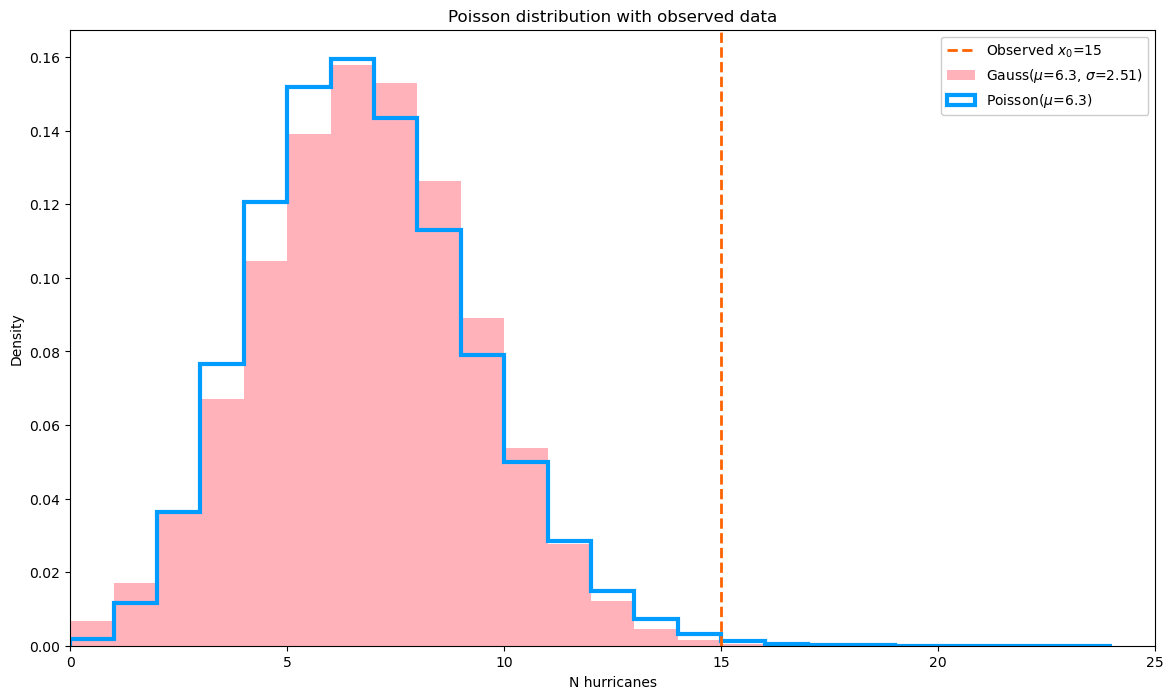

In [101]:
fig, ax = plt.subplots(ncols=1, figsize=(14,8))

XMIN = 0
XMAX = 25

xpoisson = np.arange(XMIN, XMAX, 1)
ypoisson = scipy.stats.poisson.pmf(k=xpoisson, mu=mu)
xgauss   = np.arange(XMIN, XMAX, 1)
ygauss   = scipy.stats.norm.pdf(xgauss, loc=mu, scale=sigma)

ax.set_title("Poisson distribution with observed data")
ax.set_xlabel("N hurricanes")
ax.set_ylabel("Density")

ax.hist(
    xgauss, 
    weights=ygauss, 
    bins=xgauss,
    histtype="stepfilled",
    lw=3,
    alpha=0.3,
    color="#ff001d", 
    label=f"Gauss($\mu$={mu}, $\sigma$={sigma:.2f})"
)
ax.hist(
    xpoisson, 
    weights=ypoisson, 
    bins=xpoisson,
    histtype="step",
    lw=3,
    alpha=1,
    color="#009CFF", 
    label=f"Poisson($\mu$={mu})"
)


ax.axvline(x0, color="#ff6300", lw=2, ls="--", label=f"Observed $x_0$={x0}")

ax.set_xlim(left=XMIN, right=XMAX)
ax.set_ylim(bottom=0)

ax.legend(framealpha=1)


# ZMAX = 5
# ZMIN = -ZMAX

# zgrid = np.linspace(-5, 5, 500)
# ynorm = scipy.stats.norm.pdf(zgrid, loc=0, scale=1)

# ax[1].set_title("Normal distribution with observed Z-score")
# ax[1].set_xlabel("Z")
# ax[1].set_ylabel("Density")

# ax[1].plot(
#     zgrid,
#     ynorm,
#     lw=3,
#     alpha=1,
#     color="#009CFF", 
#     label="Gauss($\mu$=0, $\sigma$=1)"
# )

# ax[1].axvline(z, color="#ff6300", lw=2, ls="--", label=f"Z-score={z2:.3f}")

# ax[1].set_xlim(left=ZMIN, right=ZMAX)
# ax[1].set_ylim(bottom=0)

# ax[1].legend(framealpha=1)

plt.show()

2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

In [177]:
pre  = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
data = np.vstack((pre, post))

means  = np.array([np.mean(x) for x in data])
sigmas = np.array([np.std(x, ddof=1)  for x in data])

sigma = np.sqrt( 0.5*np.sum(sigmas**2) )

n   = data.shape[1]
ndf = n - 1

t = np.abs(means[0]-means[1]) / ( sigma * np.sqrt(2./n) )

print(f"T = {t:.3f}")
print()

pval = scipy.stats.t.cdf(-t, loc=0, scale=1, df=ndf)  + scipy.stats.t.sf(t, loc=0, scale=1, df=ndf) 

print(f"2-tailed p-value = {pval:.5f}")
print("Since the pvalue is less than alpha/2 = 2.5% we reject the null hypothesis")

T = 3.787

2-tailed p-value = 0.00430
Since the pvalue is less than alpha/2 = 2.5% we reject the null hypothesis


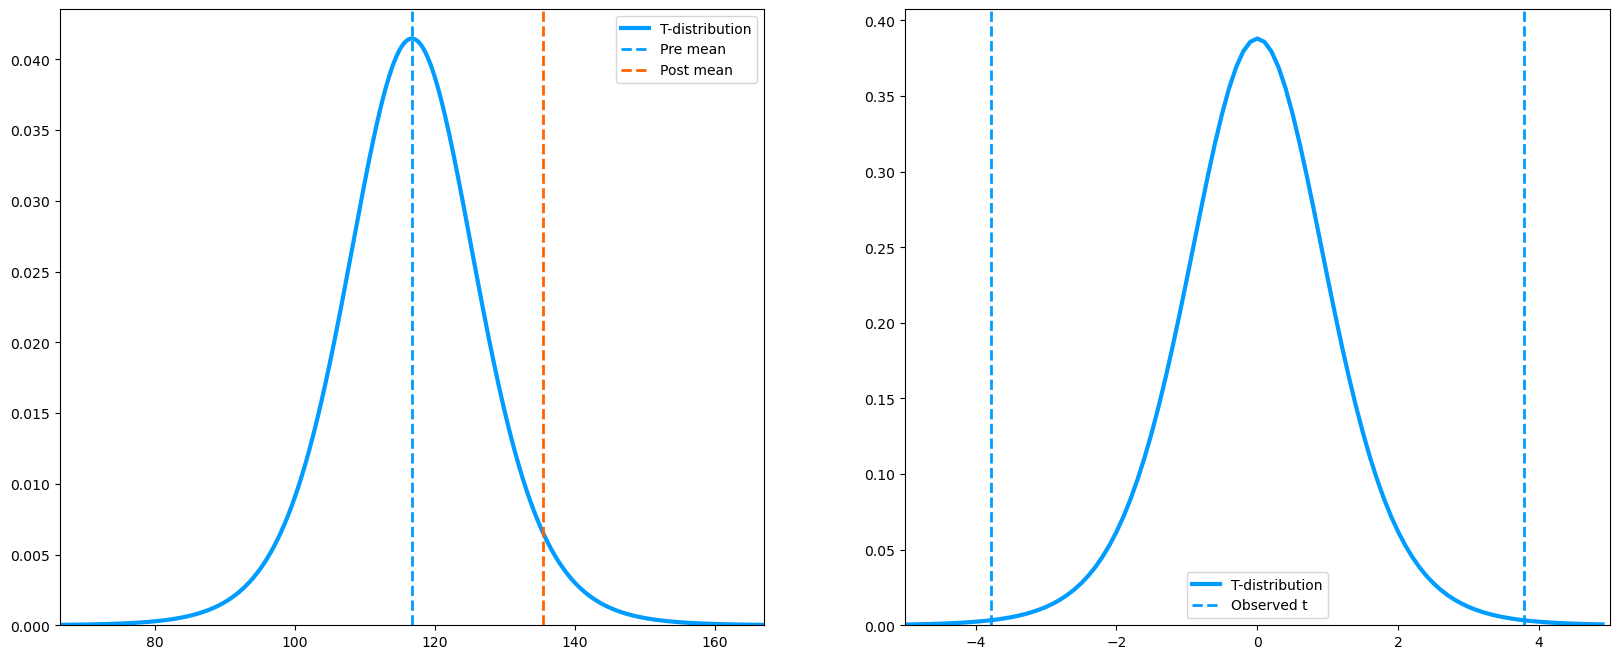

In [178]:
fig, ax = plt.subplots(ncols=2, figsize=(20,8))


XMIN = data[0].mean() - (data.max()-data.min())*0.9
XMAX = data[0].mean() + (data.max()-data.min())*0.9

xdata = np.arange(XMIN, XMAX, 0.1)
ydata = scipy.stats.t.pdf(xdata, loc=means[0], scale=sigmas[0], df=ndf)

ax[0].plot(
    xdata, 
    ydata,
    lw=3,
    alpha=1,
    color="#009CFF", 
    label=f"T-distribution"
)
ax[0].axvline(means[0], lw=2, ls="dashed", color="#009CFF", label="Pre mean")
ax[0].axvline(means[1], lw=2, ls="dashed", color="#ff6300", label="Post mean")

ax[0].set_xlim(left=XMIN, right=XMAX)
ax[0].set_ylim(bottom=0)

ax[0].legend()



XMAX = 5
XMIN = -XMAX

xt = np.arange(XMIN, XMAX, 0.1)
yt = scipy.stats.t.pdf(xt, loc=0, scale=1, df=ndf)

ax[1].plot(
    xt, 
    yt,
    lw=3,
    alpha=1,
    color="#009CFF", 
    label=f"T-distribution"
)
ax[1].axvline( t, lw=2, ls="dashed", color="#009CFF", label="Observed t")
ax[1].axvline(-t, lw=2, ls="dashed", color="#009CFF")

ax[1].set_xlim(left=XMIN, right=XMAX)
ax[1].set_ylim(bottom=0)

ax[1].legend()

plt.show()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

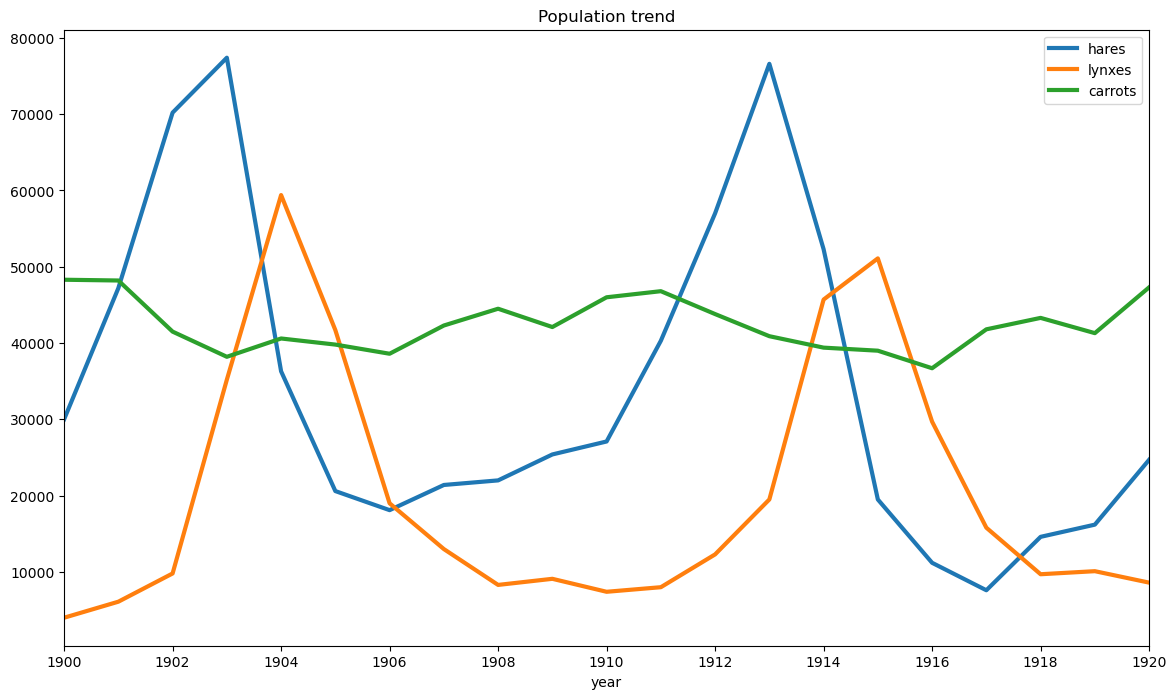

In [190]:
dataset = np.loadtxt("data/populations.txt")

labels = [
    "hares",
    "lynxes",
    "carrots"
]


colors = [
    "#1f77b4", 
    "#ff7f0e", 
    "#2ca02c"
]

# save the 4 columns into different arrays
years   = dataset[:,0]        
hares   = dataset[:,1]
lynxes  = dataset[:,2]
carrots = dataset[:,3]

# create a list for the 3 features we'll analize
features = [hares, lynxes, carrots]

fig, ax = plt.subplots(figsize=(14,8))
for i in range(len(features)):     
    ax.plot(years, features[i], lw=3, color=colors[i], label=labels[i])

ax.set_xticks(np.arange(years[0], years[-1]+1, 2.0))
ax.set_xlim(years[0], years[-1])
ax.set_xlabel("year")
ax.set_title("Population trend")
ax.legend()
plt.show()

In [207]:
time_step = 1 # data is recorded year by year

# FFT of the signals
hares_fft   = scipy.fftpack.fft(hares) 
lynxes_fft  = scipy.fftpack.fft(lynxes)
carrots_fft = scipy.fftpack.fft(carrots)

# power spectra 
h_pow = np.abs(hares_fft)
l_pow = np.abs(lynxes_fft)
c_pow = np.abs(carrots_fft) 

# corresponding frequencies
h_freq = scipy.fftpack.fftfreq(hares.size, d=time_step)
l_freq = scipy.fftpack.fftfreq(lynxes.size, d=time_step)
c_freq = scipy.fftpack.fftfreq(carrots.size, d=time_step)

# hares
h_pos_mask  = np.where(h_freq > 0)
h_freqs     = h_freq[h_pos_mask]
h_pows      = h_pow[h_pos_mask]
h_peak_freq = h_freqs[h_pow[h_pos_mask].argmax()]

# lynxes
l_pos_mask  = np.where(l_freq > 0)
l_freqs     = l_freq[l_pos_mask]
l_pows      = l_pow[l_pos_mask]
l_peak_freq = l_freqs[l_pow[l_pos_mask].argmax()]

# carrots
c_pos_mask  = np.where(c_freq > 0)
c_freqs     = c_freq[c_pos_mask]
c_pows      = c_pow[c_pos_mask]
c_peak_freq = c_freqs[c_pow[c_pos_mask].argmax()]

print(f"Frequency of the peak for hares   = {h_peak_freq:.5f} yrs^(-1) \t => Period = {1/h_peak_freq} yrs")
print(f"Frequency of the peak for lynxes  = {l_peak_freq:.5f} yrs^(-1) \t => Period = {1/l_peak_freq} yrs")
print(f"Frequency of the peak for carrots = {c_peak_freq:.5f} yrs^(-1) \t => Period = {1/c_peak_freq} yrs")

freqs = [h_freqs,     l_freqs,     c_freqs]
pows  = [h_pows,      l_pows,      c_pows]
peaks = [h_peak_freq, l_peak_freq, c_peak_freq]

Frequency of the peak for hares   = 0.09524 yrs^(-1) 	 => Period = 10.5 yrs
Frequency of the peak for lynxes  = 0.09524 yrs^(-1) 	 => Period = 10.5 yrs
Frequency of the peak for carrots = 0.09524 yrs^(-1) 	 => Period = 10.5 yrs


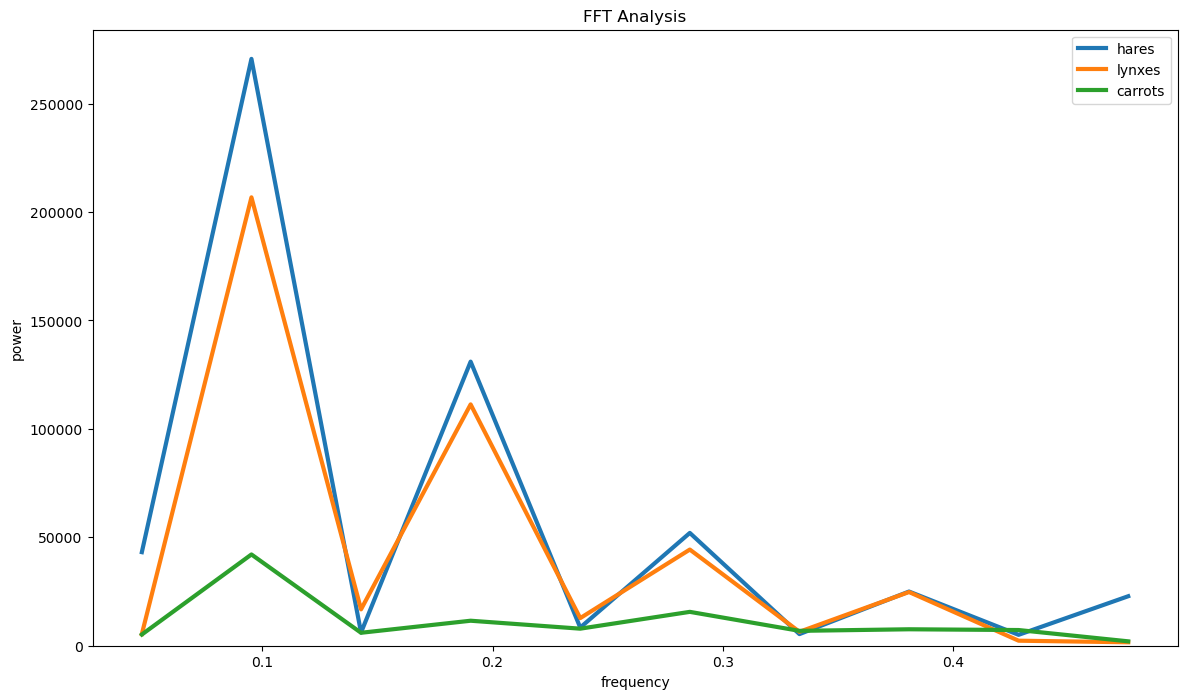

In [211]:
fig, ax = plt.subplots(figsize=(14,8))
for i in range(len(features)):     
    ax.plot(freqs[i], pows[i], lw=3, color=colors[i], label=labels[i])

ax.set_ylim(bottom=0)
    
ax.set_xlabel("frequency")
ax.set_ylabel("power")
ax.set_title("FFT Analysis")
ax.legend()
plt.show()

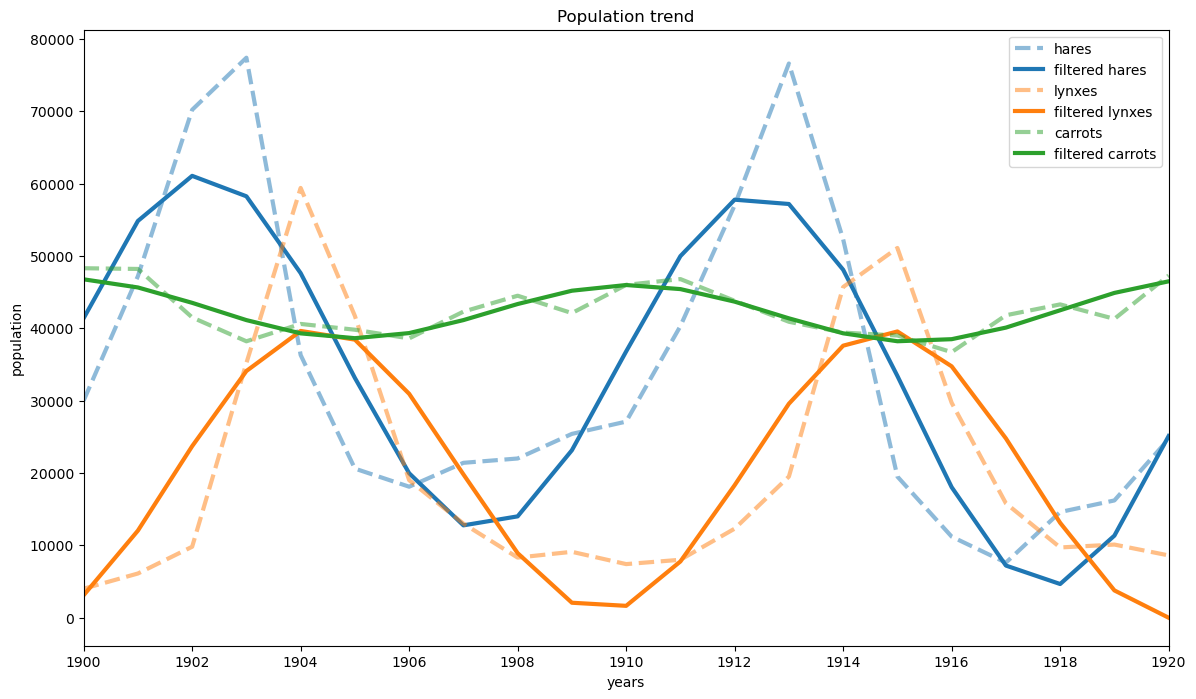

In [219]:
# hares
h_high_freq_fft = hares_fft.copy()
# set to zero all high frequency components that are larger than peak_freq
h_high_freq_fft[np.abs(h_freq) > h_peak_freq] = 0
# calculate the Inverse Fast Fourier Transform
h_filtered_sig = fftpack.ifft(h_high_freq_fft)
# only take the real part
h_real = np.real(h_filtered_sig )

# lynxes
l_high_freq_fft = lynxes_fft.copy()
l_high_freq_fft[np.abs(l_freq) > l_peak_freq] = 0
l_filtered_sig = fftpack.ifft(l_high_freq_fft)
l_real = np.real(l_filtered_sig )

# carrots
c_high_freq_fft = carrots_fft.copy()
c_high_freq_fft[np.abs(c_freq) > c_peak_freq] = 0
c_filtered_sig = fftpack.ifft(c_high_freq_fft)
c_real = np.real(c_filtered_sig )

filtered = [h_real, l_real, c_real]

fig, ax = plt.subplots(figsize=(14,8))
for i in range(len(features)):   
    ax.plot(years, features[i], lw=3, ls="--", color=colors[i], alpha=0.5, label=labels[i])
    ax.plot(years, filtered[i], lw=3, color=colors[i], label="filtered "+labels[i])

ax.set_xticks(np.arange(years[0], years[-1]+1, 2.0))
ax.set_xlim(years[0], years[-1])
    
ax.set_xlabel("years")
ax.set_ylabel("population")
ax.set_title("Population trend")
ax.legend()
plt.show()

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

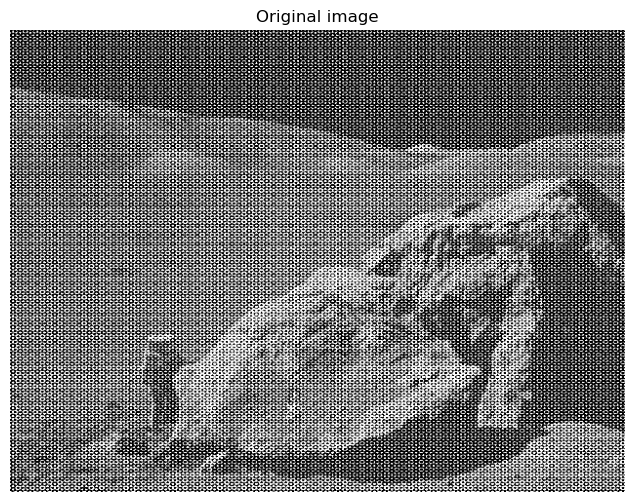

In [50]:
im = plt.imread("./data/moonlanding.png").astype(float)

fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Original image")
ax.axis('off')

ax.imshow(im, cmap="gray")

plt.show()

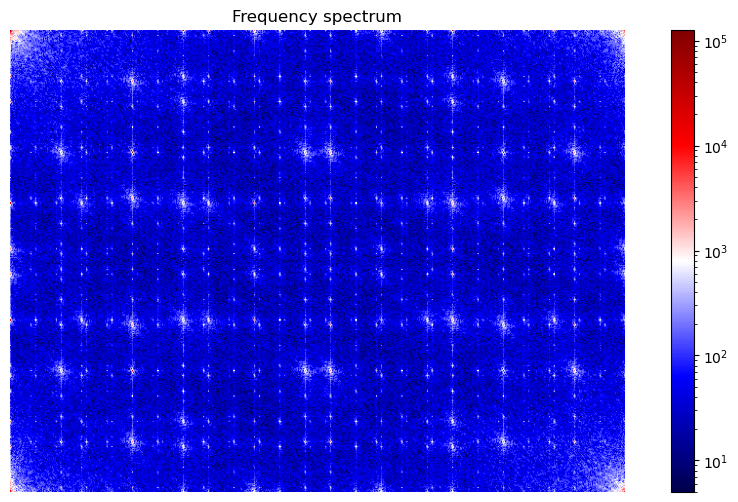

In [61]:
fft_im = fftpack.fft2(im)

fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Frequency spectrum")
ax.axis('off')

spectrum = ax.imshow(np.abs(fft_im), norm=LogNorm(vmin=5), cmap="seismic")
fig.colorbar(spectrum)


plt.show()

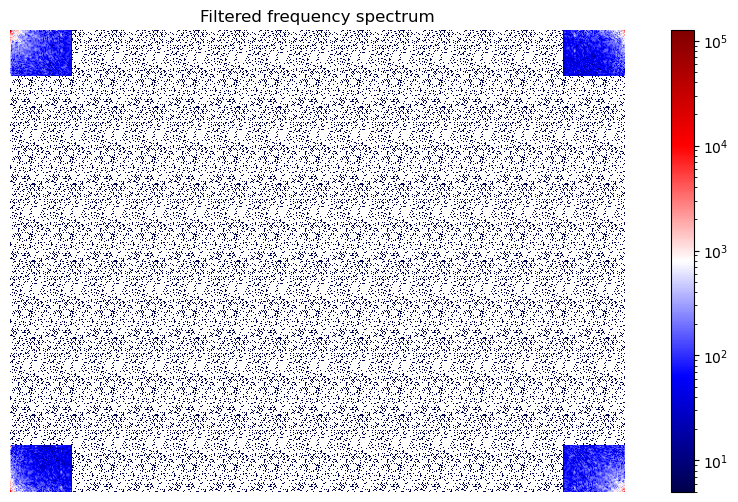

In [75]:
thrsh = 0.1

filtered_im = fft_im.copy()

rows, cols = filtered_im.shape


filtered_im[int(rows*thrsh):int(rows*(1-thrsh)), :] = 0
filtered_im[:, int(cols*thrsh):int(cols*(1-thrsh))] = 0

fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Filtered frequency spectrum")
ax.axis('off')

filtered_spectrum = ax.imshow(np.abs(filtered_im), norm=LogNorm(vmin=5), cmap="seismic")
fig.colorbar(filtered_spectrum)

plt.show()

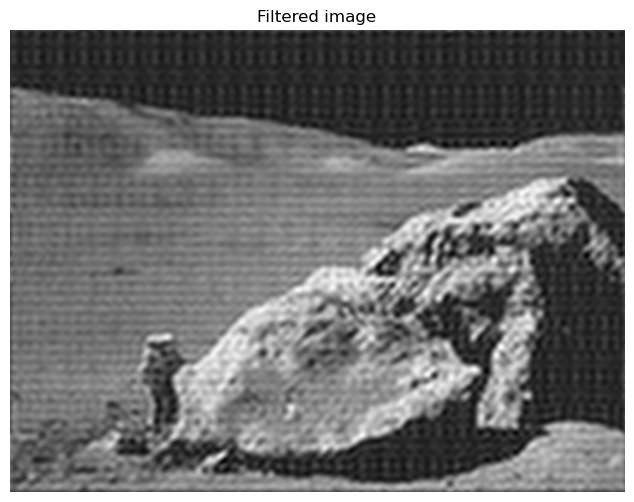

In [76]:
filtered_image = fftpack.ifft2(filtered_im).real

fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Filtered image")
ax.axis('off')

ax.imshow(filtered_image, cmap="gray")

plt.show()